# Detecting Intrusions in Cloud Dataset using LSTM

In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tabulate import tabulate
import mplcursors


%matplotlib widget

In [5]:
def getLabelName():
    return 'Status'

In [ ]:
def getStats (df):

    # Check the number of duplicate records
    num_duplicates = df.duplicated().sum()
    print(f"Number of duplicate records: {num_duplicates}")

    # Check the number of categorical and numerical features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_features = df.select_dtypes(include=['int', 'float']).columns.tolist()
    print(f"Number of categorical features: {len(categorical_features)} \n {categorical_features} \n")
    print(f"Number of numerical features: {len(numerical_features)} \n {numerical_features} \n")

    # Check the degree of imbalance on the output column (y)
    y_col = 'output'
    y_value_counts = df[getLabelName()].value_counts(normalize=True)
    imbalance_degree = np.abs(y_value_counts - 0.5).sum()
    print(f"Degree of imbalance on the output column (y): {imbalance_degree}")
    print(f'Imbalance: \n{y_value_counts}')
    
    #This function is used to check for missing values in a given dataSet
    anyMissingValuesInTheDataset = df.isnull().values.any()
    print(f'Missing values: {anyMissingValuesInTheDataset}')


In [7]:
#This function is used to check for duplicate records in a given dataSet
def checkForDulicateRecords (dataSet):
    totalRecordsInDataset = len(dataSet.index)
    numberOfUniqueRecordsInDataset = len(dataSet.drop_duplicates().index)
    anyDuplicateRecordsInTheDataset = False if totalRecordsInDataset == numberOfUniqueRecordsInDataset else True 
    print('Total number of records in the dataset: {}\nUnique records in the dataset: {}'.format(totalRecordsInDataset,numberOfUniqueRecordsInDataset))
    return anyDuplicateRecordsInTheDataset

In [8]:
#This function is used to check for missing values in a given dataSet
def checkForMissingValues (dataSet):
    anyMissingValuesInTheDataset = dataSet.isnull().values.any()
    return anyMissingValuesInTheDataset

### Read Dataset 

In [9]:
#Define file names and call loadCSV to load the CSV files
def read_dataset(filename):
    df = pd.read_csv(filename)

    print("\n***** Here is how to training dataset looks like before performing any pre-processing *****")
    print(df.head())

    print(f'Shape of dataframe: {df.shape}')
    # drop rows with null status value i.e. not 'Attack' or 'Normal'
    df = df.dropna()
    print(f'New Shape of dataframe after dropping null values: {df.shape}')

           
    return df

In [12]:
df = read_dataset("VMResourceUtilizationSlope.csv")


#Look at the statistics of the dataSet
getStats(df)


***** Here is how to training dataset looks like before performing any pre-processing *****
    LAST_POLL  VMID                                    UUID     dom  \
0  1604455173     7  "2bc1fde1-28d9-454e-8029-21a138714234"  one-33   
1  1604455142     7  "2bc1fde1-28d9-454e-8029-21a138714234"  one-33   
2  1604455113     7  "2bc1fde1-28d9-454e-8029-21a138714234"  one-33   
3  1604455082     7  "2bc1fde1-28d9-454e-8029-21a138714234"  one-33   
4  1604455055     7  "2bc1fde1-28d9-454e-8029-21a138714234"  one-33   

   rxbytes_slope  rxpackets_slope  rxerrors_slope  rxdrops_slope  \
0        88.2065          30.1414             0.0            0.0   
1        87.8708          27.3499             0.0            0.0   
2        87.8865          27.2996             0.0            0.0   
3        87.8760          27.4076             0.0            0.0   
4        87.7241          25.8210             0.0            0.0   

   txbytes_slope  txpackets_slope  ...  vdard_bytes_slope  vdawr_reqs_s

In [13]:
def encode_dataset(df):
    
    codes = df[getLabelName()].astype('category').cat.codes
    
    categories = df[getLabelName()].astype('category').cat.categories

    # encode categorical (string) values as numbers
    for column in df.columns:
        df[column] = df[column].astype('category').cat.codes
        
    return codes, categories
        
codes, categories = encode_dataset(df)

In [14]:
def generate_training_test_data(df, extra_trees_classifier):
    X = df.iloc[:, : (df.shape[1] - 1)] # dataset has 85 columns, 84 are the independent input variables

    print(f'Number of Features before feature selection: {X.shape[1]}')
    y = df[getLabelName()] # set the y to the dependent output variable
    model = extra_trees_classifier()
    model.fit(X,y)
    print(model)
    return X, y, model
    
X, y, model = generate_training_test_data(df, ExtraTreesClassifier)

Number of Features before feature selection: 43
ExtraTreesClassifier()


In [17]:
def extra_tree_classifier(threshold, model, X, df):

    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    correlations = feat_importances.nlargest(df.shape[1])

    df = pd.DataFrame(correlations).reset_index()
    df.columns = ['features', 'data']
    
    df_output = df[df['data'] >= threshold]
    
    #This is to ensure the feature selector returns features when feature correlation between X and y is 0 
    while df_output.shape[0] < 3: # features must be a minimum of 3
        
        print(f'Current Feature size before adjustment: {df_output.shape[0]}')
        threshold = round(threshold - 0.01, 2) # reduced threshold by 1% to increase number of threshold
        print(f'New Threshold: {threshold}')
        df_output = df[df['data'] >= threshold]
        print(f'Current Feature size after adjustment: {df_output.shape[0]}')
        if(threshold == 0):
            print(f'Final Correlation: {threshold * 100}%')
            break
                
    tooltip = df.data
    tt = [str(round((ttip * 100), 2)) + '% correlation' for ttip in tooltip.values]
    
    fig, ax = plt.subplots(1, figsize=(9.5,5.5))
    
    ax.bar(df['features'], df['data'], align="center")
    cursor = mplcursors.cursor(hover=mplcursors.HoverMode.Transient)
    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set(text=tt[sel.target.index])
        
    plt.title('Feature Correlation with Output - Label\n', loc='left', fontsize=22)
    plt.xlabel('Features')
    plt.yticks(fontsize=8)
    plt.xticks(rotation = 90, fontsize=8)
    plt.ylabel('Correlations')
    plt.tight_layout()
    plt.margins(x=0)
    plt.show()
       
    
    return df_output

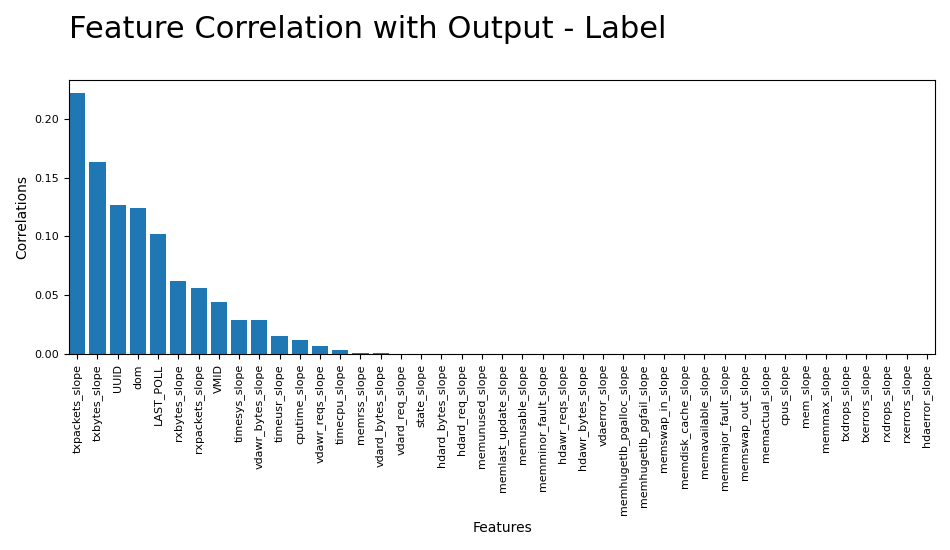

In [18]:
selected_features = extra_tree_classifier(0.04, model, X, df)

In [19]:
def check_feature_sparsity(X, selected_features):
    X = X[selected_features['features']]
    
    
    print(f'Number of Features after feature selection: {X.shape[1]}')
    print(X.isnull().sum()) # This checks to know if there are any null or zero values in the dataset
    
    # The numbers represents the count of zero values and results show there are no zero values in any of the columns
    return X

X = check_feature_sparsity(X, selected_features)
type(X)

Number of Features after feature selection: 8
txpackets_slope    0
txbytes_slope      0
UUID               0
dom                0
LAST_POLL          0
rxbytes_slope      0
rxpackets_slope    0
VMID               0
dtype: int64


pandas.core.frame.DataFrame

In [20]:
def feature_stats(X):
    print(X.describe()) #check basic statistics for each column in the dataset e.g., mean, count, max value etc.

feature_stats(X)

       txpackets_slope  txbytes_slope         UUID         dom    LAST_POLL  \
count      9594.000000    9594.000000  9594.000000  9594.00000  9594.000000   
mean        125.670315     116.873567     6.274442     2.29852  1858.288097   
std         226.042388     207.479129     4.862354     1.63177  1117.526030   
min           0.000000       0.000000     0.000000     0.00000     0.000000   
25%           0.000000       0.000000     1.000000     1.00000   933.250000   
50%           0.000000       0.000000     6.000000     2.00000  1785.000000   
75%          70.000000      78.000000    10.000000     4.00000  2747.750000   
max         652.000000     597.000000    13.000000     5.00000  3996.000000   

       rxbytes_slope  rxpackets_slope         VMID  
count    9594.000000      9594.000000  9594.000000  
mean      246.171357       135.218991     6.551178  
std       316.301793       157.377290     1.731400  
min         0.000000         0.000000     0.000000  
25%        49.000000   

In [21]:
def output_stats(y):
    print (y.shape)
    
    imbalance = y.value_counts() #check dataset for imbalances

    #imbalanace is the distribution of the training outcome. If the dataset is bias with more outcomes, the model will be better at predicting that outcome
    if(imbalance.shape[0] > 1): # condition prevents code from throwing error if the dataset has only on type of output (e.g., 0 for days without intrusion)
        print(f'imbalance of this predicted variable is: {round(imbalance[0]/imbalance[1], 2) * 100}% \n\nImbalance Variables\n{imbalance}')

output_stats(y)

(9594,)
imbalance of this predicted variable is: 32.0% 

Imbalance Variables
1    7288
0    2306
Name: Status, dtype: int64


### Rescale the dataset using StandardScaler so that all records have a relative size

In [22]:
from sklearn.preprocessing import StandardScaler

def scale_X(X):
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled
    
X = scale_X(X)
feature_stats(pd.DataFrame(X))

                 0             1             2             3             4  \
count  9594.000000  9.594000e+03  9.594000e+03  9.594000e+03  9.594000e+03   
mean      0.000000 -1.421974e-16 -4.739914e-17  9.479828e-17 -9.479828e-17   
std       1.000052  1.000052e+00  1.000052e+00  1.000052e+00  1.000052e+00   
min      -0.555988 -5.633321e-01 -1.290480e+00 -1.408678e+00 -1.662946e+00   
25%      -0.555988 -5.633321e-01 -1.084807e+00 -7.958151e-01 -8.277984e-01   
50%      -0.555988 -5.633321e-01 -5.644522e-02 -1.829519e-01 -6.558408e-02   
75%      -0.246295 -1.873711e-01  7.662444e-01  1.042775e+00  7.959620e-01   
max       2.328577  2.314216e+00  1.383262e+00  1.655638e+00  1.912996e+00   

                  5             6             7  
count  9.594000e+03  9.594000e+03  9.594000e+03  
mean  -5.924893e-18  1.184979e-17  2.606953e-16  
std    1.000052e+00  1.000052e+00  1.000052e+00  
min   -7.783206e-01 -8.592475e-01 -3.783944e+00  
25%   -6.233971e-01 -5.351686e-01 -8.959563e-01

### Split Dataset into trainning and Test Dataset

In [23]:
from sklearn.model_selection import train_test_split
# convert X from numpy array back to panda dataframe
# X = pd.DataFrame(X, columns=selected_features.features)

def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state=10)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(X, y)

### Reshape the y-axis of the datasets from 1 column to 2 columns to match type of attacks

In [24]:
# # This code changes the "is_attack" column from 1 to 5 which maps to the number of attacks to enable the NN model classify better
def reshape_y(output):
    onehot = pd.get_dummies(output)
    output = onehot.to_numpy()
    
    return output

### Define Method to Reshape x-axis of dataset from 2D to 3D 

In [25]:
def reshape_x(data):
    # Reshape the data into a 3D array
    num_samples = data.shape[0] 
    input = np.zeros((num_samples, time_steps, num_features))
    for i in range(num_samples):
        if i+time_steps < num_samples: #perform check to prevent slicing array out of bound
            input[i, :, :] = data[i:i+time_steps, :]
            
    return input

### Find the Highest Common Factor between no of rows in X_train and X_test, and assign that value as time_steps

In [26]:
# The hcf is used to prevent data shape mismatch for training data or test data
def hcf(a, b):
    #Calculates the highest common factor of two numbers using the Euclidean algorithm.
    while b != 0:
        a, b = b, a % b
    return a

### Define the LSTM model architecture

In [27]:
# Set the number of time steps and features
time_steps = hcf(X_train.shape[0], X_test.shape[0])
print(f'X_train: {X_train.shape} \n X_test: {X_test.shape}')
print(f'Time_step: {time_steps}')
num_features = selected_features.shape[0]

# reshape the X_train, X_test to be 3d array & trim the y_test and y_train to fit the row count of X_train and X_test

reshaped_X_train = reshape_x(X_train)
reshaped_X_test = reshape_x(X_test)
reshaped_y_train = reshape_y(y_train)
reshaped_y_test = reshape_y(y_test)

num_attacks = reshaped_y_train.shape[1]
print(num_attacks)

X_train: (6715, 8) 
 X_test: (2879, 8)
Time_step: 1
2


In [28]:
def build_LSTM(num_features, num_attacks):
    lstm_model = Sequential(name='LSTM_IDS')
    lstm_model.add(LSTM(num_features, input_shape=(time_steps, num_features), activation='relu', dropout=0.2))
    lstm_model.add(Dense(num_attacks, activation='softmax'))
    adam = Adam(learning_rate=0.001)
    lstm_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return lstm_model

### Train LSTM Model  

In [29]:
lstm_model = build_LSTM(num_features, num_attacks)

lstm_model.summary()

hist = lstm_model.fit(reshaped_X_train, reshaped_y_train, 
                      epochs = 10, 
                      validation_data=(reshaped_X_test, reshaped_y_test), 
                      shuffle=True, 
                      verbose=1, 
                      use_multiprocessing = True, 
                      workers=4)

Model: "LSTM_IDS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
210/210 [==============================] - 4s 7ms/step - loss: 0.5026 - accuracy: 0.9260 - val_loss: 0.2721 - val_accuracy: 0.9861
Epoch 2/10
210/210 [==============================] - 1s 5ms/step - loss: 0.1606 - accuracy: 0.9854 - val_loss: 0.0893 - val_accuracy: 0.9910
Epoch 3/10
210/210 [==============================] - 1s 5ms/step - loss: 0.0785 - accuracy: 0.9912 - val_loss: 0.0547 - val_accuracy: 0.9944
Epoch 4/10
210/210 [==========

### Get the True performance of the LSTM model trained above on training and test data 

In [30]:
lstm_train_metric = lstm_model.evaluate(reshaped_X_train, reshaped_y_train, use_multiprocessing = True, workers = 4, return_dict=True)
lstm_test_metric = lstm_model.evaluate(reshaped_X_test, reshaped_y_test, use_multiprocessing = True, workers=4, return_dict=True)
print(f'Accuracy during training: {round(lstm_train_metric["accuracy"]*100, 2)}% and loss: {round(lstm_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(lstm_test_metric["accuracy"]*100, 2)}% and loss: {round(lstm_test_metric["loss"], 4)}')

90/90 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9979
Accuracy during training: 99.84% and loss: 0.0094
Accuracy during test: 99.79% and loss: 0.0121


### Save the LSTM model trained above 

In [31]:
lstm_model.save('lstm_Cloud_IDS.h5')

### Plot the Training and Test accuracy of the model

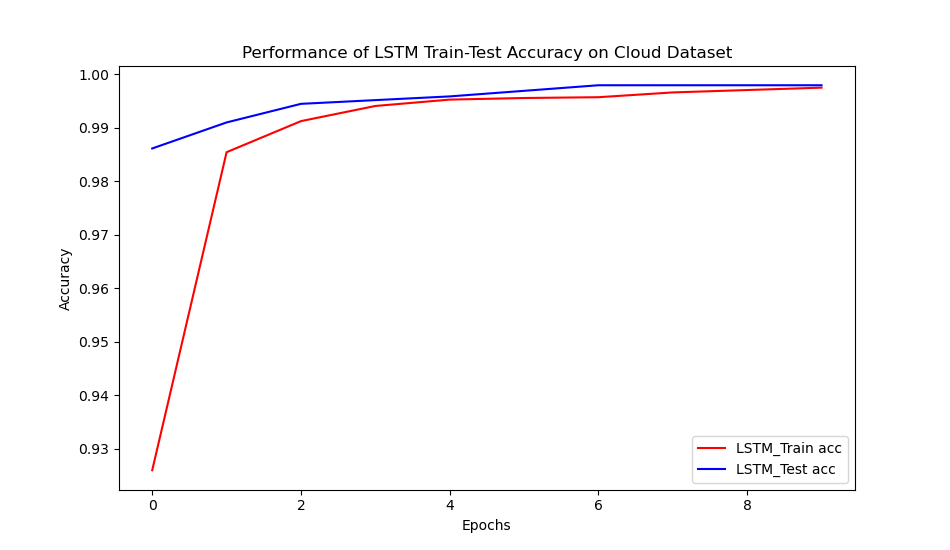

In [32]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(10), hist.history['accuracy'], 'r', label='LSTM_Train acc')
plt.plot(range(10), hist.history['val_accuracy'], 'b', label='LSTM_Test acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Performance of LSTM Train-Test Accuracy on Cloud Dataset")
plt.legend()
plt.show()

### Plot the loss of the model

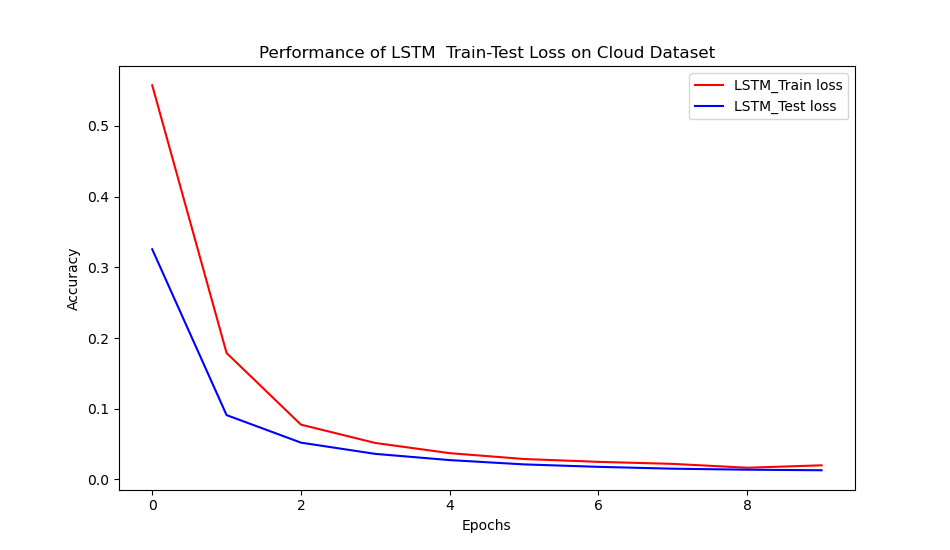

In [487]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(10), hist.history['loss'], 'r', label='LSTM_Train loss')
plt.plot(range(10), hist.history['val_loss'], 'b', label='LSTM_Test loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Performance of LSTM  Train-Test Loss on Cloud Dataset")
plt.legend()
plt.show()

### Load the model 

In [33]:
loaded_model = load_model('lstm_Cloud_IDS.h5')
loaded_model.summary()

Model: "LSTM_IDS"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________


### Confirm  the Loaded Model is the same as trained Model

In [34]:
lstm_train_metric = lstm_model.evaluate(reshaped_X_train, reshaped_y_train, use_multiprocessing = True, workers = 4, return_dict=True)
lstm_test_metric = lstm_model.evaluate(reshaped_X_test, reshaped_y_test, use_multiprocessing = True, workers=4, return_dict=True)
print(f'Accuracy during training: {round(lstm_train_metric["accuracy"]*100, 2)}% and loss: {round(lstm_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(lstm_test_metric["accuracy"]*100, 2)}% and loss: {round(lstm_test_metric["loss"], 4)}')

90/90 [==============================] - 0s 3ms/step - loss: 0.0121 - accuracy: 0.9979
Accuracy during training: 99.84% and loss: 0.0094
Accuracy during test: 99.79% and loss: 0.0121
